In [79]:
%load_ext autoreload
%autoreload 2

from basic_vae_module import VAE
import torch
from torch.utils.data import DataLoader

from dataset import get_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = VAE.load_from_checkpoint('vae-1.cpkt', map_location=device)

mean = [194.7155, 139.2602, 145.4779]
std = [36.0167, 38.9894, 43.4381]
def denormalize_image(image):
    image = image.cpu().detach().permute(1, 2, 0).numpy()
    image = image * std + mean
    image = image.astype(np.uint8)
    return image

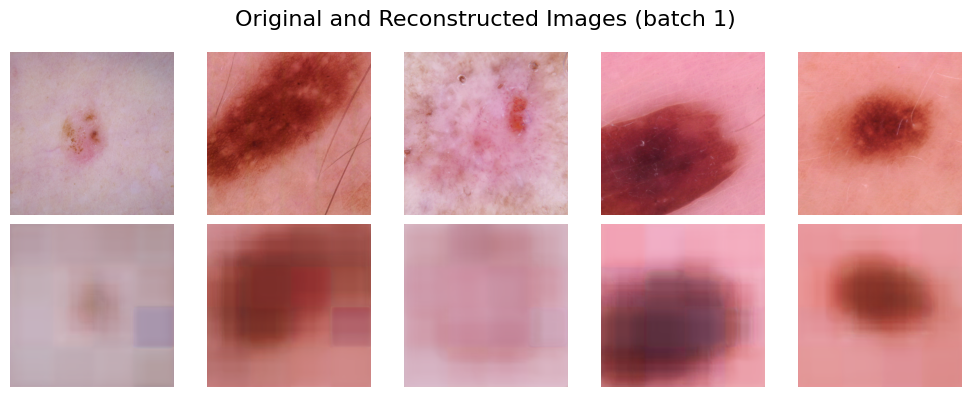

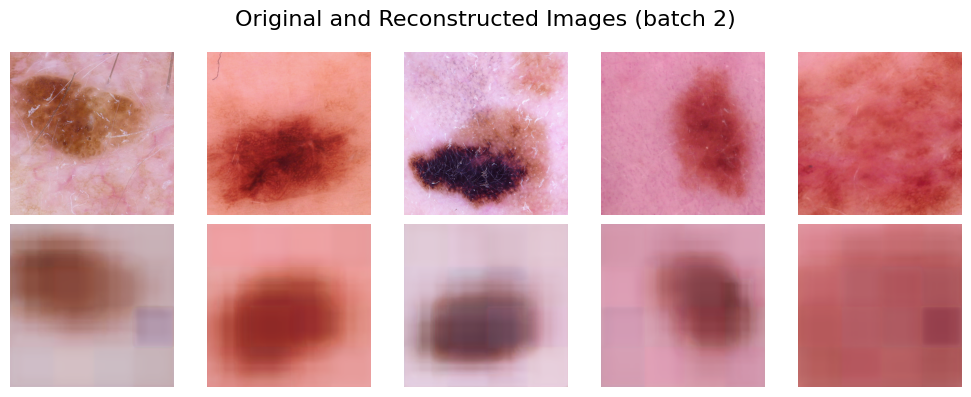

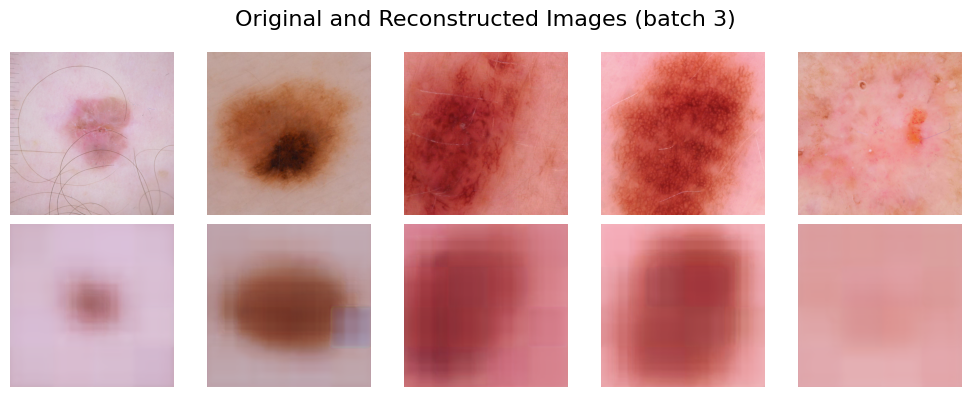

In [19]:
# Visualize some images from the validation set

val_set = get_dataset(dataset_name = "validation")
val_loader = DataLoader(val_set, batch_size=5, shuffle=True, drop_last=False, num_workers=1)
counter = 1
for batch in val_loader:
    imgs, labels = batch
    imgs = imgs.to(device)
    original_imgs = imgs
    
    recon_imgs = model.forward(imgs)
    
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    
    # add original images
    for i, ax in enumerate(axes[0]):
        image = denormalize_image(original_imgs[i])
        ax.imshow(image)
        ax.axis('off')

    # add reconstructed images
    for i, ax in enumerate(axes[1]):
        image = denormalize_image(recon_imgs[i])
        ax.imshow(image)
        ax.axis('off')
        
    plt.suptitle(f"Original and Reconstructed Images (batch {counter})", fontsize=16)
    plt.tight_layout()

    plt.show()

    counter += 1
    if counter >= 4:
        break

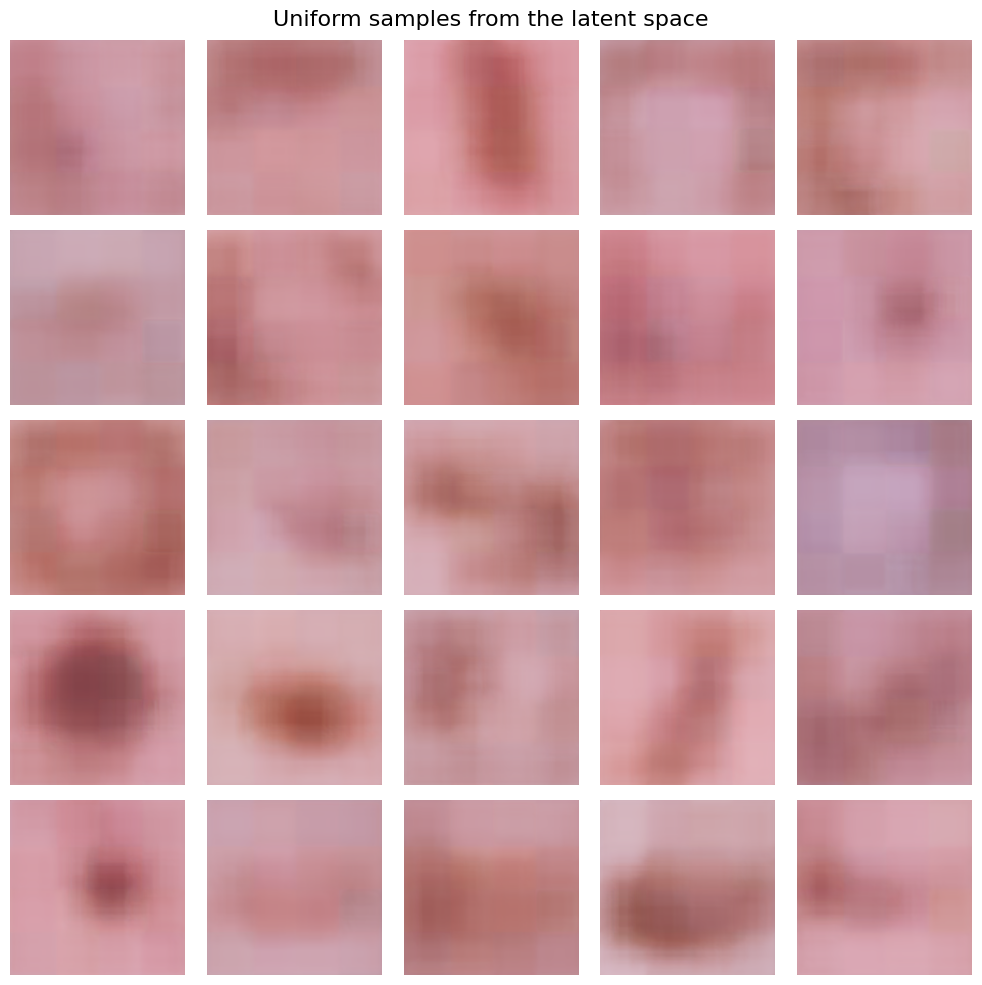

In [20]:
# Visualize random samples from the latent space

num_samples = 25
random_imgs = model.generate_samples(num_samples)
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# add original images
for i, ax in enumerate(axes.flat):
    image = denormalize_image(random_imgs[i])
    ax.imshow(image)
    ax.axis('off')

plt.suptitle("Uniform samples from the latent space", fontsize=16)
plt.tight_layout()

plt.show()

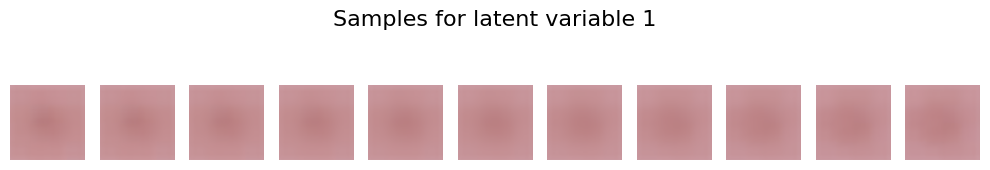

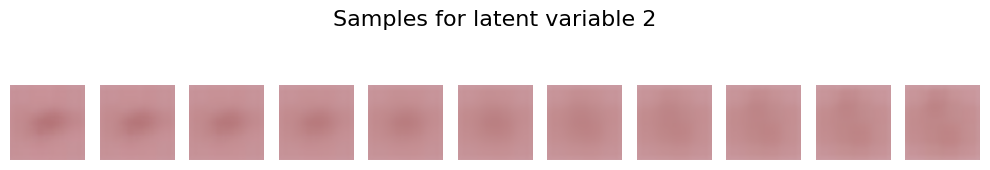

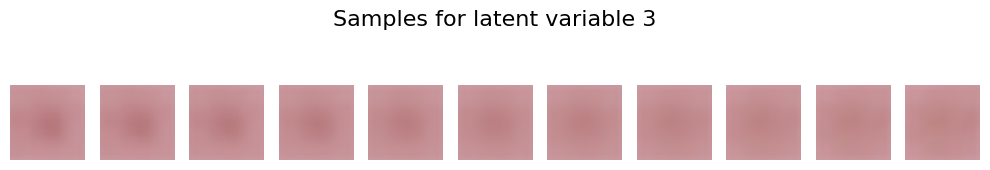

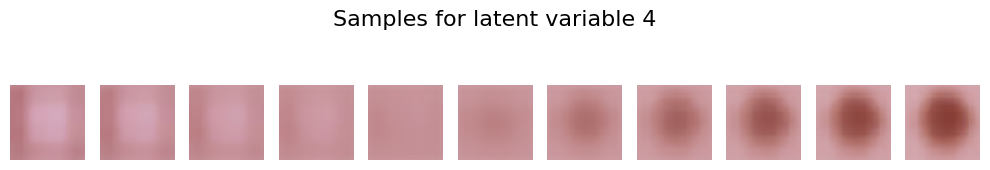

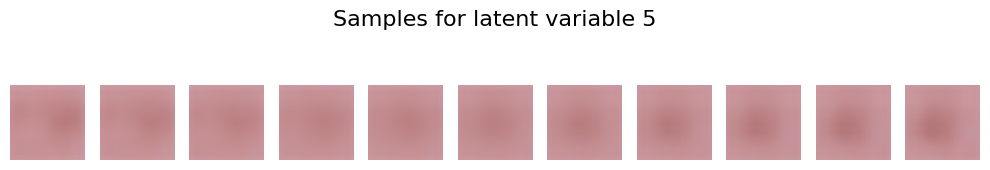

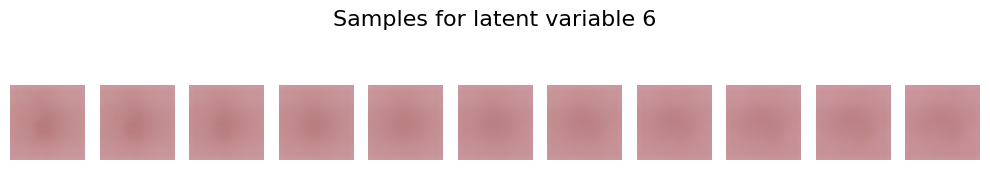

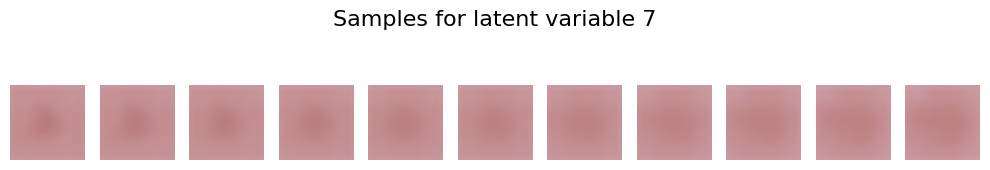

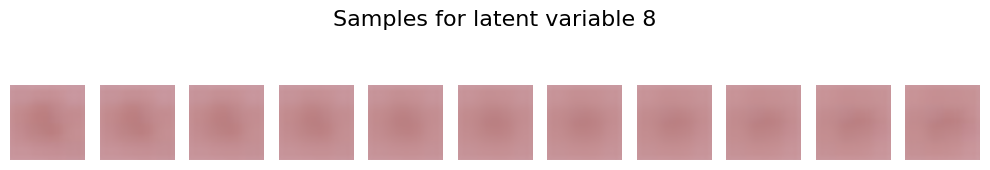

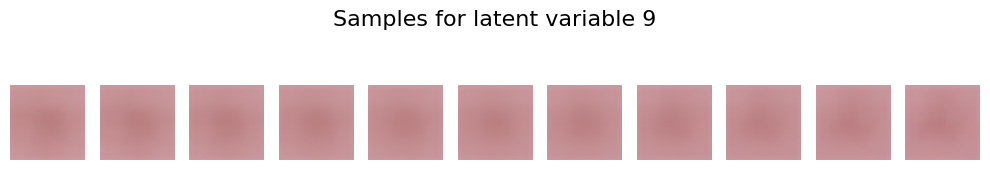

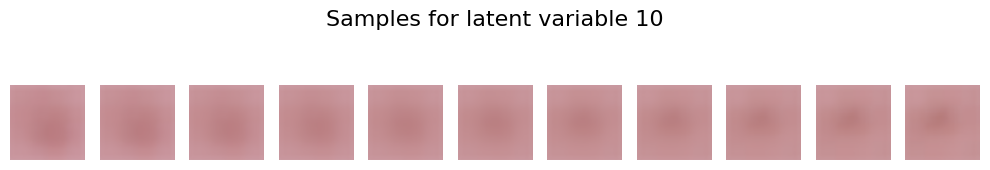

In [21]:
# Visualize samples for each latent variable

for i in range(10):
    
    latent_variable = i

    random_imgs = model.generate_samples_for_latent_variable(latent_variable)

    fig, axes = plt.subplots(1, 11, figsize=(10, 2))

    for i, ax in enumerate(axes.flat):
        image = denormalize_image(random_imgs[i])
        ax.imshow(image)
        ax.axis('off')

    plt.suptitle(f"Samples for latent variable {latent_variable + 1}", fontsize=16)
    plt.tight_layout()

    plt.show()

100


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/matplotlib/patches.py:738: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/matplotlib/transforms.py:2041: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx


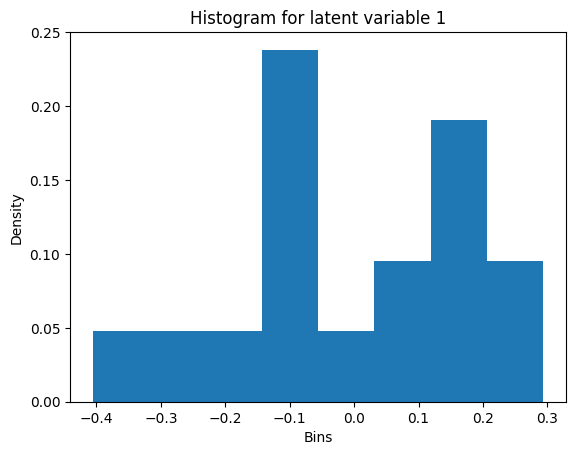

0.25


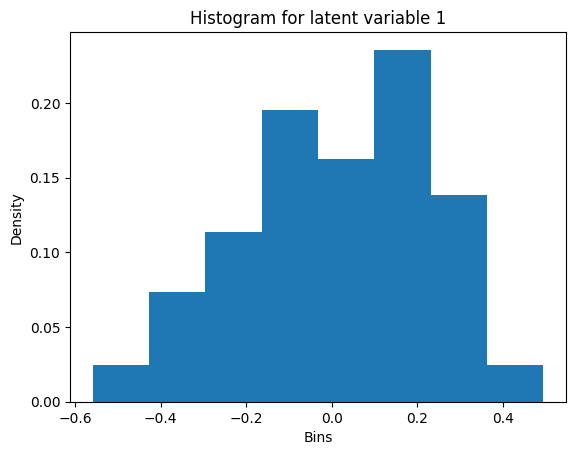

0.24999999999999997


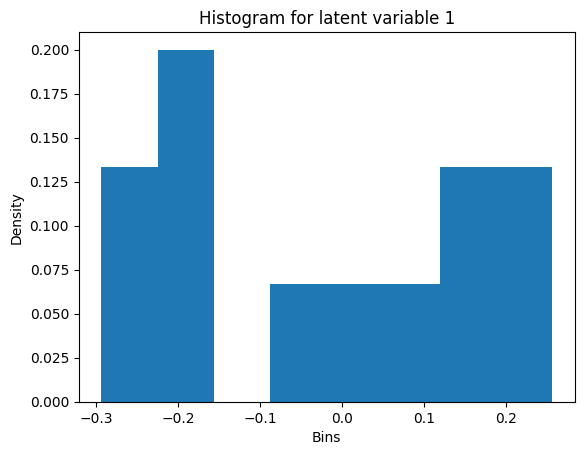

0.25000000000000006


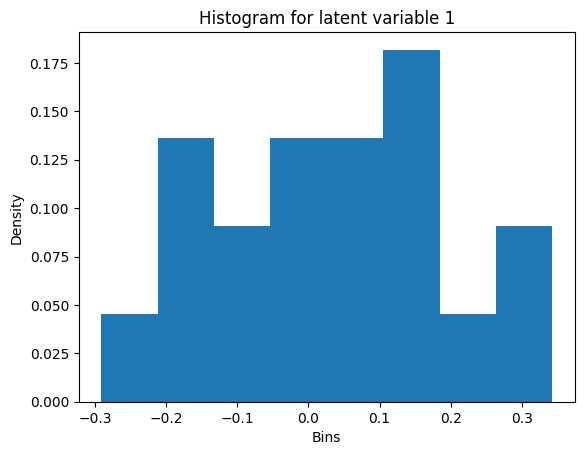

0.24999999999999997
[0.01171875 0.01367187 0.01171875 0.01367188 0.01171875 0.01367187
 0.01367187 0.01025391 0.01171875 0.01171875 0.01367187 0.01171875
 0.01171875 0.01171875 0.01025391 0.01171875 0.01171875 0.01025391
 0.01171875 0.01171875 0.01025391 0.00045975 0.00357583 0.00357583
 0.00064365 0.00160912 0.00357583 0.00107275 0.00178792 0.00321825
 0.00321825 0.00357583 0.00160912 0.00107275 0.00321825 0.00064365
 0.00160912 0.00107275 0.00321825 0.00080456 0.00107275 0.00160912
 0.00160912 0.00160912 0.00321825 0.00321825 0.00178792 0.00321825
 0.00321825 0.00321825 0.00080456 0.00357583 0.00064365 0.00053637
 0.00321825 0.00160912 0.00119194 0.00053637 0.00080456 0.00321825
 0.00321825 0.00160912 0.00160912 0.00107275 0.00107275 0.00321825
 0.00053637 0.00119194 0.00107275 0.00321825 0.00357583 0.00107275
 0.00080456 0.00053637 0.00107275 0.00107275 0.00107275 0.00160912
 0.00160912 0.00321825 0.00321825 0.00160912 0.00160912 0.00321825
 0.00059597 0.00119194 0.00321825 0.003218

In [34]:
def calculate_sample_probabilities(dataset_name, visualize_latent_variables=False):
    data_set = get_dataset(dataset_name=dataset_name, id_as_label=True)

    data_loader = DataLoader(data_set, batch_size=1, shuffle=False, drop_last=False, num_workers=1)
    latent_repr_chunks = []
    all_isic_ids = [[], [], [], []]
    latent_repr_lists = [[], [], [], []]
    counter = 0
    for batch in data_loader:
        counter += 1
        if counter % 100 == 0:
            print(counter)
       
        imgs, labels = batch
        ids = labels[0]
        class_label = labels[1][0].item()
        imgs = imgs.to(device)
        original_imgs = imgs

        chunk_latent_repr = model.encode(imgs)
        latent_repr_lists[class_label].append(chunk_latent_repr)
        all_isic_ids[class_label].extend(ids)    

    latent_repr = []
    for i in range(4):
        latent_repr.append(torch.cat(latent_repr_lists[i], dim=0))
    
    sample_p = []
    
    for j in range(4):
        
        sample_p.append(np.zeros(latent_repr[j].shape[0]))
        bins = 10

        for i in range(256):
            latent_distribution = latent_repr[j][:,i].cpu()
            hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

            bin_edges[0] = -float('inf')
            bin_edges[-1] = float('inf')

            smoothing_fac = 0.0

            bin_idx = np.digitize(latent_distribution, bin_edges) 
            hist_density = hist_density / np.sum(hist_density)

            p = 1.0/(hist_density[bin_idx-1] + smoothing_fac)
            p = p/np.sum(p) * 0.25

            # This is a bit different to what is described in the paper
            sample_p[j] = np.maximum(p, sample_p[j])

            if i <= 0 and visualize_latent_variables:
                plt.bar(bin_edges[:-1], hist_density, width=np.diff(bin_edges), align='edge')
                plt.xlabel('Bins')
                plt.ylabel('Density')
                plt.title(f"Histogram for latent variable {i+1}")
                plt.show()


        sample_p[j] = sample_p[j]/np.sum(sample_p[j])*0.25
        #print(sample_p[j])
        print(np.sum(sample_p[j]))
    
    print(np.concatenate(sample_p))
    print(np.concatenate(all_isic_ids))
    
    return np.concatenate(sample_p), np.concatenate(all_isic_ids)

val_sample_p, val_isic_ids = calculate_sample_probabilities("validation", True)

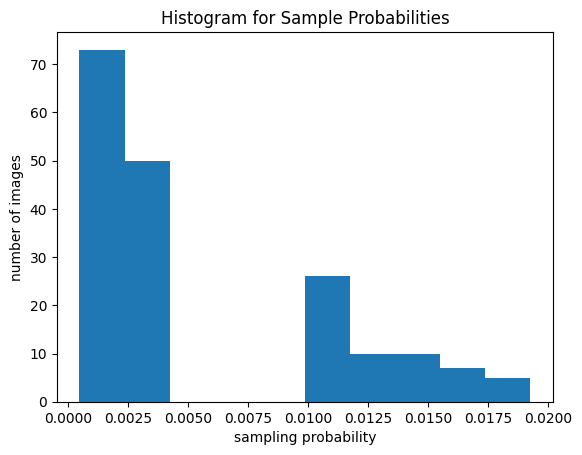

In [35]:
# Plot sample probabilities
bins=10
hist_density, bin_edges =  np.histogram(val_sample_p, density=False, bins=bins)
plt.bar(bin_edges[:-1], hist_density, width=np.diff(bin_edges), align='edge')
plt.xlabel('sampling probability')
plt.ylabel('number of images')
plt.title("Histogram for Sample Probabilities")
plt.show()

[ 21  93 123  88  53  57  73 107  66  84]
ISIC_0034321
ISIC_0034443
ISIC_0034496
ISIC_0034437
ISIC_0034377
ISIC_0034385
ISIC_0034417
ISIC_0034465
ISIC_0034401
ISIC_0034431


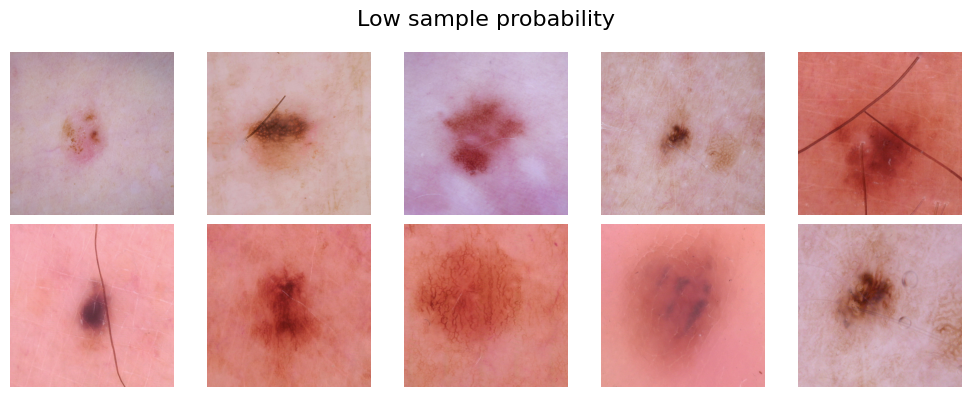

[145 154 153 144 149 148 151 157 156 155]
ISIC_0034333
ISIC_0034409
ISIC_0034406
ISIC_0034323
ISIC_0034361
ISIC_0034346
ISIC_0034404
ISIC_0034486
ISIC_0034478
ISIC_0034416


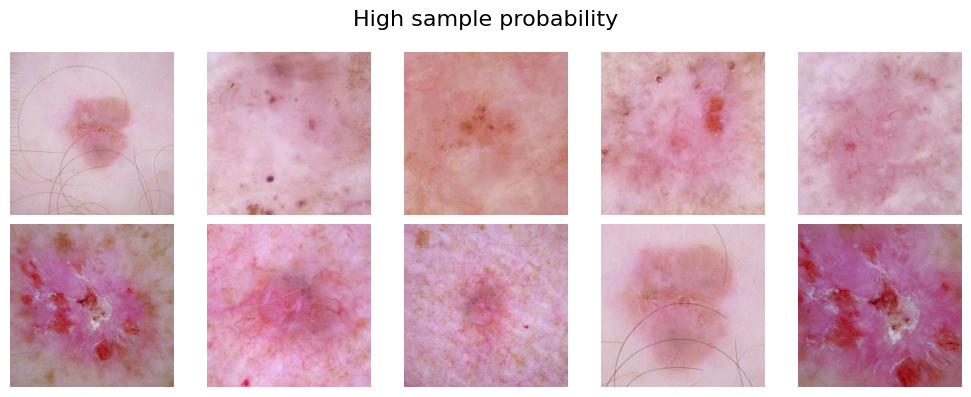

In [105]:
# Plot images with high and low sampling probability

argmins = np.argsort(val_sample_p)[:10]
print(argmins)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    isic_id = val_isic_ids[argmins[i]]
    print(isic_id)
    image = val_set.get_image_from_isic_id(isic_id)
    image = denormalize_image(image)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle(f"Low sample probability", fontsize=16)
plt.tight_layout()
plt.show()



argmaxs = np.argsort(val_sample_p)[-10:]
print(argmaxs)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    isic_id = val_isic_ids[argmaxs[i]]
    print(isic_id)
    image = val_set.get_image_from_isic_id(isic_id)
    image = denormalize_image(image)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle(f"High sample probability", fontsize=16)
plt.tight_layout()
plt.show()



In [106]:
# write probabilities to csv file

data_dict = {"isic_id": val_isic_ids, "sample_probability":val_sample_p.tolist()}
dataframe = pd.DataFrame(data_dict)
dataframe.to_csv("./val_sample_probabilities.csv")

In [38]:
train_sample_p, train_isic_ids = calculate_sample_probabilities("train")

data_dict = {"isic_id": train_isic_ids, "sample_probability": train_sample_p.tolist()}
dataframe = pd.DataFrame(data_dict)
dataframe.to_csv("./train_sample_probabilities.csv")


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
0.25
0.25000000000000006
0.25
0.25
[3.03689642e-05 1.30820153e-04 4.25165542e-05 ... 6.81908398e-05
 5.45526657e-04 2.04572513e-04]
['ISIC_0024310' 'ISIC_0024313' 'ISIC_0024315' ... 'ISIC_0034303'
 'ISIC_0034315' 'ISIC_0034318']


In [14]:
## Other version from UVA:

# A placeholder for the sampling probabilities for the images.
training_sample_p = np.zeros(latent_repr.shape[0])

# Consider the distribution for each latent variable.
for i in range(256):
    # Extract the latent means of the respective latent dimension.
    latent_distribution = latent_repr[:, i].cpu()

    # Generate a histogram of the latent distribution.
    hist_density, bin_edges = np.histogram(latent_distribution, density=True, bins=bins)

    # Set the boundaries of the bins to -/+ infinity.
    bin_edges[0] = -float("inf")
    bin_edges[-1] = float("inf")
    # Use the digitize function to see in which bin each sample falls.
    bin_idx = np.digitize(latent_distribution, bin_edges)

    # Convert the hist density to a probability of the respective bin.
    hist_bin_probability = hist_density / np.sum(hist_density)

    # Invert the density function to compute the sampling probability!
    sample_probabilities = 1.0 / (hist_bin_probability[bin_idx - 1] + smoothing_fac)
    # Add 1 to remove negative probabilities and use Log Sum Trick
    log_sample_probabilities = np.log(sample_probabilities + 1)

    # At the end.
    training_sample_p += log_sample_probabilities

# Overall normalization.
training_sample_p /= np.sum(training_sample_p)
print(training_sample_p)

# Plot a hist of current sample probabilities and image samples of the bins.
#self.plot_sample_prob_hist(training_sample_p.copy(), images, bins, epoch, model_name)


NameError: name 'latent_repr' is not defined